<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Workshop_3/Jupyter-notebooks/DoE-2factor_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
from numpy.random import rand

# Design of experiments 

Let's do the example in python ... 

## Two-level full factorial design
To find which parameters that will have most influence on the quality, we need to perform experiments. For this purpose, lets consider a a two-level, three-variable experimental design - also written as 2$^3$, with n=2 levels for each factor,  k=3 different factors. We start by encoding each fo the three variables to something generic: (x1,x2,x3). A dataframe with input variable values is then populated.

In this design, each observation data point consists of three input variable values and an output variable value, (A,B,C,y), and can be thought of as a point in 3D space (A,B,C) with an associated point value of y. Alternatively, this might be thought of as a point in 4D space (the first three dimensions are the location in 3D space where the point will appear, and the y value is when it will actually appear).


In [43]:
inputs_labels = {'S' : 'Steel Temperature',
                 'T' : 'Oil Temperature',
                 'C' : 'Carbon Level'}

dat = [('S',830,910),
       ('T',70,120),
       ('C',0.5,0.7)]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
S,830.0,910.0,Steel Temperature
T,70.0,120.0,Oil Temperature
C,0.5,0.7,Carbon Level


We encode the variable values. For an arbitrary variable value  $\phi_i$, the value of the variable can be coded to be between -1 and 1 according to the formula:

\begin{equation}
x_i = \frac{\phi_i-avg(\phi)}{span(\phi)}
\end{equation}

where the average and the span of the variable $\phi_i$ are defined as: 

\begin{equation}
avg(\phi) = \frac{\phi_{high}+\phi_{low}}{2}
\end{equation}

\begin{equation}
span(\phi) = \frac{\phi_{high}-\phi_{low}}{2}
\end{equation}

In [44]:
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
S,830.0,910.0,Steel Temperature,-1.0,1.0
T,70.0,120.0,Oil Temperature,-1.0,1.0
C,0.5,0.7,Carbon Level,-1.0,1.0


The input variable values consist of all possible input value combinations, which we can produce using the itertools module:

In [45]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1],[-1,1]))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [50]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['S','T','C']
results

,S,T,C
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1


Now we implement the observed outcomes (4 repetitions):

In [56]:
repetitions=1
#y= [67,59, 61, 52, 79,59,90,61,75,52,87] 
y=[67, 79, 59, 90, 61, 75, 52, 87]

In [57]:
results['y']= y


The variable inputs_df contains all input variables for the expeirment design, and results_df contains the inputs and responses for the experiment design; these variables are the encoded levels. To obtain the original, unscaled values, which allows us to check what experiments must be run, we can always convert the dataframe back to its originals by defining a function to un-apply the scaling equation. This is as simple as finding

In [58]:
real_experiment = results

var_labels = []
for var in ['S','T','C']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'] , 
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Steel Temperature,Oil Temperature,Carbon Level
0,830.0,70.0,0.5
1,910.0,70.0,0.5
2,830.0,120.0,0.5
3,910.0,120.0,0.5
4,830.0,70.0,0.7
5,910.0,70.0,0.7
6,830.0,120.0,0.7
7,910.0,120.0,0.7


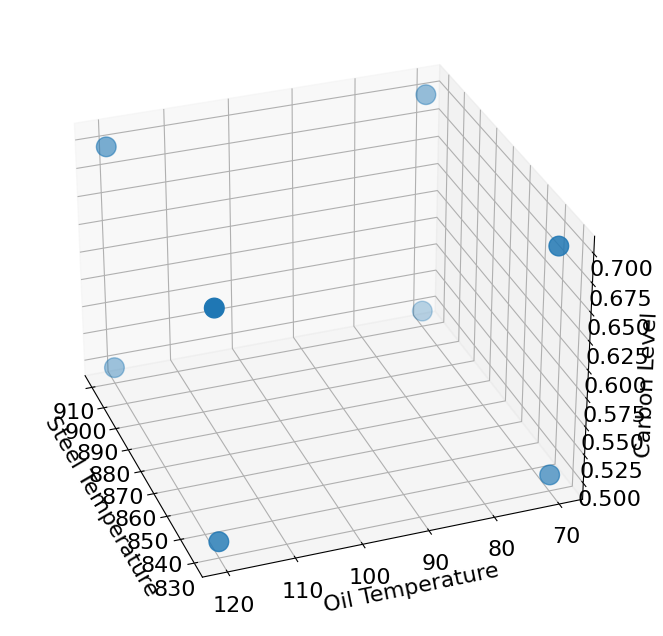

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(real_experiment['Steel Temperature'],
             real_experiment['Oil Temperature'],
             real_experiment['Carbon Level'],
           s=200)
ax.set_xlabel('Steel Temperature')
ax.set_ylabel('Oil Temperature')
ax.set_zlabel('Carbon Level');
ax.view_init(30, 160)
plt.show()

# Computing main effects

Now we compute the main effects of each variable using the results of the experimental design. We'll use some shorthand Pandas functions to compute these averages: the groupby function, which groups rows of a dataframe according to some condition (in this case, the value of our variable of interest  x$_i$ ).

In [60]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['S','T','C']

average_main_effects = {}

print('Average main effects')
for key in labels:
        average_effects = results.groupby(key)['y'].mean()
        average_main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(average_main_effects)

Average main effects
{'S': 23.0, 'T': 1.5, 'C': -5.0}


# Analyzing Main Effects
The main effect of a given variable (as defined by Yates 1937) is the average difference in the level of response as the input variable moves from the low to the high level. If there are other variables, the change in the level of response is averaged over all combinations of the other variables.

Now that we've computed the main effects, we can analyze the results to glean some meaningful information about our system. The first variable A has a negative effect of -1.65 - this indicates that when A goes from its low level to its high level, it decreases the value of the response. This means A should be increased, if we want an increased response. However, this effect was the smallest, meaning it's might have a very small effect on the response.

This might be the case if, for example, changing the value of the input variables were capital-intensive. A company might decide that they can only afford to change one variable, A, B, or C. If this were the case, increasing A would not be the way to go.

In contrast, increasing the variables B and C will result in an increase in the response, since these have a positive main effect. These variables should be kept at their higher levels, or increased, to increase the response.

## Two-Way Interactions
In addition to main effects, a factorial design will also reveal interaction effects between variables - both two-way interactions and three-way interactions. We can use the itertools library to compute the interaction effects using the results from the factorial design.

We'll use the Pandas groupby function again, grouping by two variables this time.

In [62]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results.groupby([key[0],key[1]])['y'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('S', 'T'): 10.0, ('S', 'C'): 1.5, ('T', 'C'): 0.0}

This one-liner is a bit hairy:

```
twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
```

What this does is, computes the two-way variable effect with a multi-step calculation, but does it with a list comprehension. 

First, let's just look at this part:

```
i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1]
```
This computes the prefix i*j, which determines if the interaction effect effects[i][j] is positive or negative. We're also looping over one additional dimension; we multiply by 1/2 for each additional dimension we loop over. These are all summed up to yield the final interaction effect for every combination of the input variables.

If we were computing three-way interaction effects, we would have a similar-looking one-liner, but with i, j, and k:
```
i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1]
```

## Analyzing Two-Way Interactions

As with main effects, we can analyze the results of the interaction effects analysis to come to some useful conclusions about our physical system. A two-way interaction is a measure of how the main effect of one variable changes as the level of another variable changes. A negative two-way interaction between A and C means that if we increase  C, the main effect of A will be to decrease the response; or, alternatively, if we increase A, the main effect of C will be to decrease the response.

In this case, we see that the B−C interaction effect is the largest, and it is positive. This means that if we increase both B and C, it will increase our response - make the equipment last longer. 


## Three-Way Interactions
Now let's compute the three-way effects (in this case, we can only have one three-way effect, since we only have three variables). We'll start by using the itertools library again, to create a tuple listing the three variables whose interactions we're computing. Then we'll use the Pandas groupby() feature to partition each output according to its inputs, and use it to compute the three-way effects.

In [64]:
import itertools

threeway_labels = list(itertools.combinations(labels, 3))

threeway_effects = {}
for key in threeway_labels:
    
    effects = results.groupby([key[0],key[1],key[2]])['y'].mean()
    
    threeway_effects[key] = sum([ i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1] ])

threeway_effects

{('S', 'T', 'C'): 0.5}

In [65]:
effects=[] #pd.DataFrame({})
indexes=[]
for i,k in enumerate(average_main_effects.keys()):
    effects.append(abs(average_main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k)
for i,k in enumerate(threeway_effects.keys()):
    effects.append(abs(threeway_effects[k]))
    indexes.append(k)    
    
effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column
effects_df["cum_percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame
effects_df

,Standardized effect,cum_percentage
S,23.0,55.42
"(S, T)",10.0,79.52
C,5.0,91.57
T,1.5,95.18
"(S, C)",1.5,98.80
"(S, T, C)",0.5,100.00
"(T, C)",0.0,100.00


## Analysis of Three-Way Effects
While three-way interactions are relatively rare, typically smaller, and harder to interpret, a negative three-way interaction esssentially means that increasing these variables, all together, will lead to interactions which lower the response (the lifespan of the equipment), and the opposite for positive values. This is esily visualized in a Pareto plot:

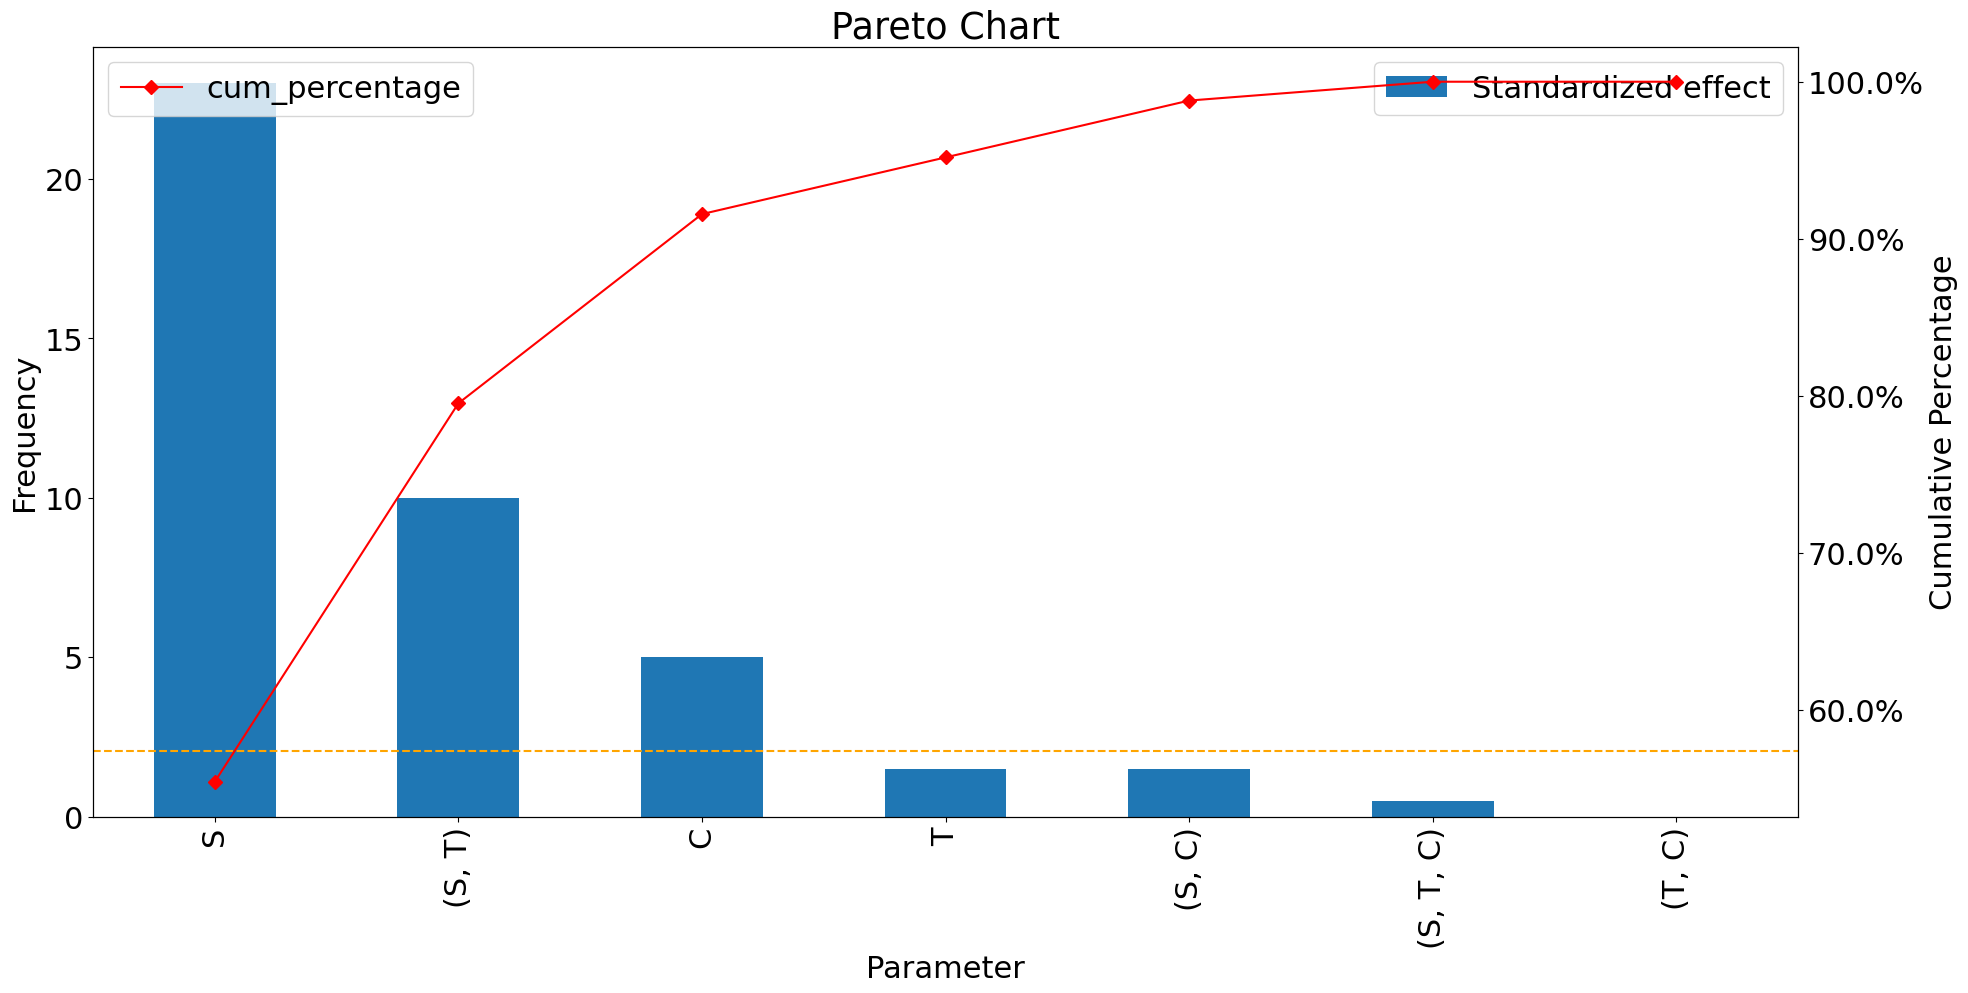

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({'font.size': 22})
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.set_title("Pareto Chart")
ax.set_xlabel("Parameter")
ax.set_ylabel("Frequency");
effects_df.plot.bar(y='Standardized effect', ax=ax)
ax.axhline(2.06, color="orange", linestyle="dashed")

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
#ax2.plot(effects_df.index, effects_df["cum_percentage"], color="red", marker="D", ms=7)
effects_df.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

However, looking at the quantile-quantile plot of the effects answers the question in a more visual way.

## Quantile-Quantile Effects Plot
We can examine the distribution of the various input variable effects using a quantile-quantile plot of the effects. Quantile-quantile plots arrange the effects in order from least to greatest, and can be applied in several contexts (as we'll see below, when assessing model fits). If the quantities plotted on a quantile-qantile plot are normally distributed, they will fall on a straight line; data that do not fall on the straight line indicate significant deviations from normal behavior.

In the case of a quantile-quantile plot of effects, non-normal behavior means the effect is paticularly strong. By identifying the outlier points on thse quantile-quantile plots (they're ranked in order, so they correspond to the lists printed above), we can identify the input variables most likely to have a strong impact on the responses.

We need to look both at the top (the variables that have the largest overall positive effect) and the bottom (the variables that have the largest overall negative effect) for significant outliers. When we find outliers, we can add them to a list of variabls that we have decided are important and will keep in our analysis.

((array([-1.31487275, -0.74397649, -0.3471943 ,  0.        ,  0.3471943 ,
          0.74397649,  1.31487275]),
  array([ 0. ,  0.5,  1.5,  1.5,  5. , 10. , 23. ])),
 (8.01624386748085, 5.928571428571429, 0.8650320572476503))

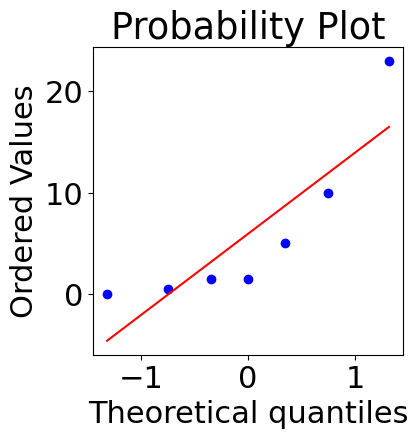

In [89]:
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
fig = figure(figsize=(4,4))


stats.probplot(effects_df["Standardized effect"], dist="norm", plot=plt)

#sm.qqplot(effects_df["Standardized effect"],line ='45')

# Fitting a Polynomial Response Surface
While identifying general trends and the effects of different input variables on a system response is useful, it's more useful to have a mathematical model for the system. The factorial design we used is designed to get us coefficients for a linear model  $\hat{y}$ that is a linear function of input variables x$_i$, and that predicts the actual system response  y:

\begin{equation}
\hat{y}=a_0+a_1x_1+a_2x_2+a_3x_3+a_{12}x_1x_2+a_{13}x_1x_3+a_{23}x_2x_3+a_{123}x_1x_2x_3
\end{equation} 

To determine these coefficients, we can obtain the effects we computed above. When we computed effects, we defined them as measuring the difference in the system response that changing a variable from -1 to +1 would have. Because this quantifies the change per two units of x, and the coefficients of a polynomial quantify the change per one unit of x, the effect must be divided by two.

In [69]:
s = "yhat = "

s += "%0.3f "%(results['y'].mean())

for i,k in enumerate(average_main_effects.keys()):
    if(average_main_effects[k]<0):
        s += "%0.3f %s "%( average_main_effects[k]/2.0, k )
    else:
        s += "+ %0.3f %s "%( average_main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])
    else:
        s += "+ %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])

for i,k in enumerate(threeway_effects.keys()):
    if(threeway_effects[k]<0):
        s += " %0.3f %s %s %s"%( threeway_effects[k]/2.0, k[0],k[1], k[2])
    else:
        s += "+ %0.3f %s %s %s"%( threeway_effects[k]/2.0, k[0],k[1], k[2])


print(s)

yhat = 71.250 + 11.500 S + 0.750 T -2.500 C + 5.000 S T+ 0.750 S C+ 0.000 T C+ 0.250 S T C
